In [1]:
from waylay import WaylayClient, WaylayError

# deploy  your own statistical models (BYOML)
This notebook illustrates how to use `queries.query` and `byoml` services through the Waylay Python SDK.

We create a simple statistical model, train it, deploy it to the [Bring Your Own Model](https://docs.waylay.io/features/byoml/) server, and test it.

In [2]:
waylay_client = WaylayClient.from_profile('staging')

The following calls illustrate how to check your access to the BYOML services, list currently deployed models,
and get the metadata for an existing model.

In [3]:
waylay_client.byoml.about.health()

'OK: byoml-1.5.1'

In [4]:
waylay_client.byoml.model.list()

[{'createdOn': '2021-08-18T09:13:20.589000+00:00',
  'description': 'vhekfh',
  'framework': 'sklearn',
  'framework_version': '0.22',
  'metadata': {'description': 'vhekfh'},
  'name': 'anomaly-detector',
  'updatedBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
  'updatedOn': '2021-08-18T09:13:20.589000+00:00',
  'version': '1'},
 {'createdBy': 'users/f0981778-feed-4d08-823e-dc65e2b8a502',
  'createdOn': '2021-11-22T11:02:52.402000+00:00',
  'description': 'Battery cell remaining cycle life prediction.',
  'framework': 'sklearn',
  'framework_version': '0.24',
  'metadata': {'description': 'Battery cell remaining cycle life prediction.'},
  'name': 'battery-remaining-cycles',
  'updatedBy': 'users/f0981778-feed-4d08-823e-dc65e2b8a502',
  'updatedOn': '2021-11-22T11:03:16.670000+00:00',
  'version': '1'},
 {'createdBy': 'users/f0981778-feed-4d08-823e-dc65e2b8a502',
  'createdOn': '2021-11-22T11:00:55.643000+00:00',
  'description': 'Battery cell total cycle life prediction.',
  'fr

## gathering test data
For this example we use timeseries data already stored on the platform, and query it using the `queries.query` api/

In [5]:
waylay_client.queries.query.list()

['151CF multiple aggregations',
 '151D8 space',
 'arch',
 'battery-life-testset2',
 'battery-life-testset-sdk0.3',
 'bert-666',
 'bert_test',
 'boo',
 'boo2',
 'byoml-query']

In [6]:
train_query = dict(
    resource='weather_data',
    metric='temperature', 
    freq='PT1H',
    aggregation='mean',
    until='2022-01-08T00:00:00Z',
    data=[dict(metric='temperature')]
)
train_df = waylay_client.queries.query.execute(train_query)
train_df

resource,weather_data
metric,temperature
aggregation,mean
timestamp,
2022-01-01 00:00:00+00:00,107.333333
2022-01-01 01:00:00+00:00,111.000000
2022-01-01 02:00:00+00:00,106.000000
2022-01-01 03:00:00+00:00,106.000000
2022-01-01 04:00:00+00:00,3403.666667
...,...
2022-01-07 19:00:00+00:00,11.000000


## creating a model
We create a simple [sklearn outlier detection](https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection) model and fit it to the above data.

In [7]:
from sklearn.covariance import EllipticEnvelope
import pandas as pd

cov_model = EllipticEnvelope(random_state=0, contamination=0.05).fit(train_df)

## validate the model locally
we use a modified query to retrieve a dataset that validates the model locally (using the sklearn `predict` call)

<AxesSubplot:xlabel='timestamp'>

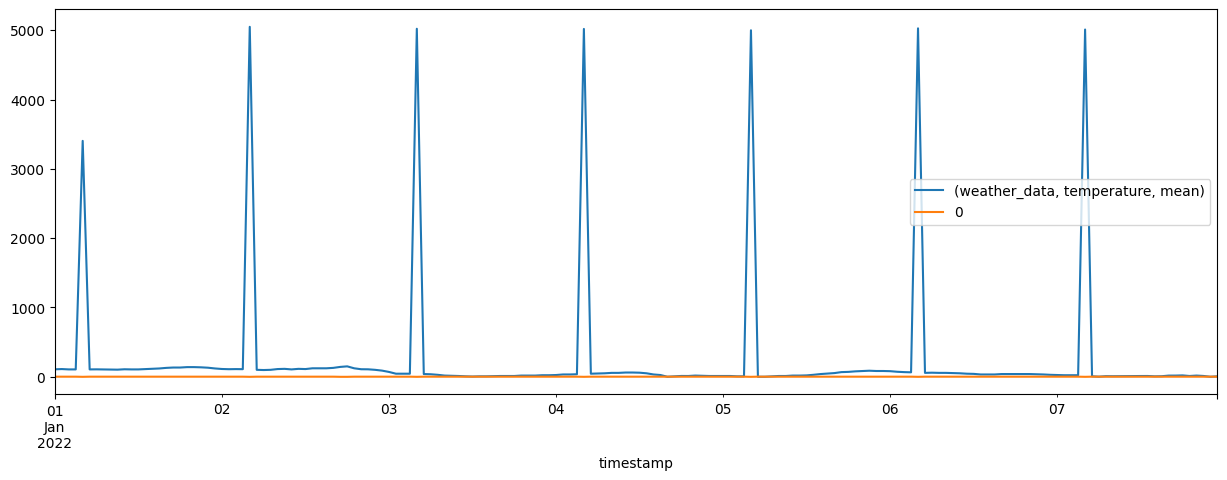

In [8]:
validation_query = dict(train_query)
validation_query['until']='2022-01-08'
df_validate = waylay_client.queries.query.execute(validation_query)
df_estimate=pd.DataFrame(
    cov_model.predict(df_validate), 
    index=df_validate.index
)
pd.concat([df_validate,df_estimate], axis=1).plot(figsize=(15,5))

## upload the model to BYOML
we upload the model under a the name `live-coding` (but first delete any existing model under that name)

In [9]:
model_name="live-coding"

In [10]:
try:
    waylay_client.byoml.model.remove(model_name)
except WaylayError as exc:
    print(exc)
waylay_client.byoml.model.upload(model_name, cov_model, framework="sklearn", description="live coding !!!")

{'createdOn': '2021-01-04T00:00:00+00:00',
 'description': 'live coding !!!',
 'framework': 'sklearn',
 'framework_version': '0.24',
 'message': 'Model successfully uploaded',
 'metadata': {'description': 'live coding !!!'},
 'name': 'live-coding',
 'updatedOn': '2021-01-04T00:00:00+00:00',
 'version': '1'}

In [11]:
waylay_client.byoml.model.get(model_name)

{'createdBy': 'users/1b2c6668-b42a-44fe-8ca7-8170e998a9f1',
 'createdOn': '2022-09-01T14:20:41.165000+00:00',
 'description': 'live coding !!!',
 'framework': 'sklearn',
 'framework_version': '0.24',
 'metadata': {'description': 'live coding !!!'},
 'name': 'live-coding',
 'ready': False,
 'supported_endpoints': [],
 'updatedBy': 'users/1b2c6668-b42a-44fe-8ca7-8170e998a9f1',
 'updatedOn': '2022-09-01T14:21:06.661000+00:00',
 'version': '1'}

## use the BYOML model
It takes a few seconds until the model is ready. The service will return a _409_ error if byoml is still preparing the deployment.

You might need to retry the next cell a few times until it is ready.

In [12]:
try:
    result = waylay_client.byoml.model.predict(model_name, df_validate.values.tolist())
except WaylayError as exc:
    result = str(exc)
result

[1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

By default the data is returned as a _numpy_ array.

You can use the `raw` or `response_constructor` parameters if this doesn't suite your needs.
See [Custom Response Handling](Custom%20Response%20Handling.ipynb) for more details.

,is_anomaly
0,1
1,1
2,1
3,1
4,-1
...,...
163,1
164,1
165,1
166,1


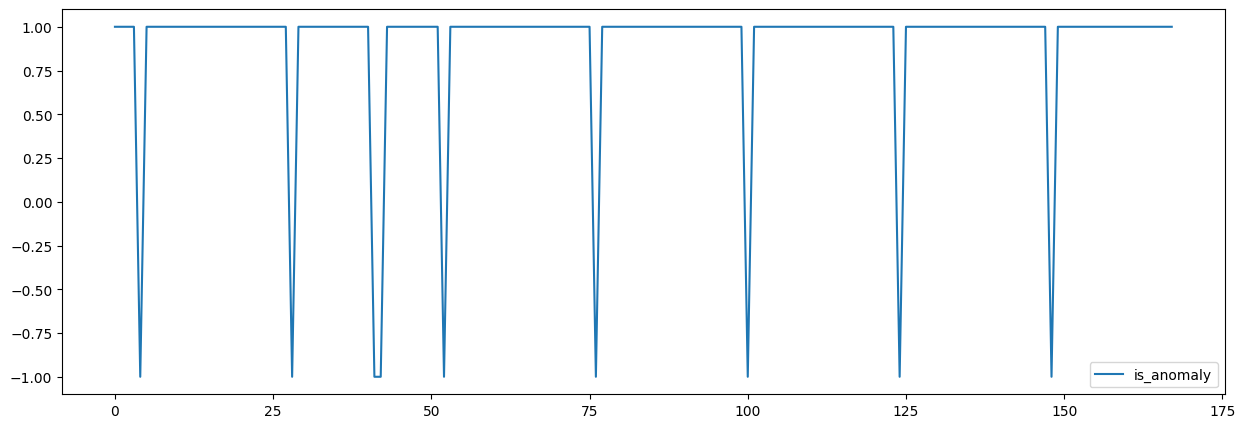

In [13]:
def to_anomaly_df(data):
    return pd.DataFrame(data, columns=['is_anomaly'])

try:
    predictions = waylay_client.byoml.model.predict(
        model_name, df_validate.values.tolist(),
        response_constructor=to_anomaly_df
    )
    predictions.plot(figsize=(15,5))
except WaylayError as exc:
    predictions = str(exc)
predictions

Byoml models can be deleted as follows.
(in this case we check that previous cells executed correctly before deleting)

In [14]:
result='ignoring delete'
if isinstance(predictions, pd.DataFrame):
    try:
        result = waylay_client.byoml.model.remove(model_name)
    except WaylayError as exc:
        result = str(exc)
result

{'message': 'Model live-coding: all versions deleted',
 'name': 'live-coding',
 'versions': ['0.0.1']}